# 5. 폐렴아 기다려라!

## 모델 순서도

## Model 성능개선을 위한 학습 History

### Step1 (CNN Model)

Batch size 16 -> 32 변경 결과 : 로스 증가 및 정확도 하락으로 다시 16으로 원복

Loss: 0.8347125053405762,
Accuracy: 0.7596153616905212,
Precision: 0.7298850417137146,
Recall: 0.9769230484962463

### Step2 (CNN Model)

데이터 Augumentation 적용(좌우반전)

결과 : 로스 증가 및 정확도 하락으로 이미지 증강방법 변경

Loss: 1.2396695613861084,
Accuracy: 0.7003205418586731,
Precision: 0.6765217185020447,
Recall: 0.9974358677864075

데이터 Augumentation 적용(이미지 회전, 대비, 밝기, 색조, 채도 변경)

결과 : 비교군과 결과 대동소이 함. 오히려 로스 증가로 적용하지 않음

Loss: 0.5711646676063538,
Accuracy: 0.8381410241127014,
Precision: 0.8054968118667603,
Recall: 0.9769230484962463

### Step3 (RasNet18)

Loss: 1.7940261363983154,
Accuracy: 0.6570512652397156,
Precision: 0.6456953883171082,
Recall: 1.0

### Step4 (RasNet18) 데이터 증강(좌우반전) -> 가장 좋음

데이터 증강(좌우반전)

Loss: 0.523777186870575,
Accuracy: 0.8621794581413269,
Precision: 0.8601895570755005,
Recall: 0.9307692050933838

### Step5 (RasNet18) 데이터 증강(좌우반전/ 이미지 회전, 대비, 밝기, 색조, 채도 변경)


Loss: 0.9214202761650085,
Accuracy: 0.8349359035491943,
Precision: 0.7971014380455017,
Recall: 0.9871794581413269

### Step6 (RasNet18)

Loss: 0.743279218673706,
Accuracy: 0.8189102411270142,
Precision: 0.7928118109703064,
Recall: 0.9615384340286255





## 5-4. 폐렴을 진단해보자 (1)

### 데이터셋

사용할 데이터는 캐글의 Chest X-Ray Images 입니다.

데이터의 구성은 ~/aiffel/chest_xray/data 하위에 3개의 폴더 (train, test, val)로 구성되며, 각 이미지 카테고리 (폐렴 / 정상)에 대한 하위 폴더를 포함합니다. 5,856 개의 X-Ray 이미지 (JPEG)와 2 개의 범주 (폐렴 / 정상)가 있습니다. 전체 데이터의 크기는 총 1.2GB 가량 됩니다.

(에디터 주) 캐글에서 다운로드한 데이터는 chest_xray 하위에 chest_xray 폴더가 중복으로 포함되어 있어서 전체 데이터의 크기가 2.5GB인 경우가 있습니다. 중복된 데이터는 필요하지 않습니다.

해당 이미지는 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X선 영상입니다. 

### 폐렴이란?
우리가 데이터를 직접 분석하기 전에 폐렴에 대해서 알아야겠죠? 폐렴은 무엇일까요? 요즘.. 코로나 때문에 폐렴에 대한 지식을 어느 정도 가졌을 것으로 생각됩니다.

폐렴(pneumonia 뉴모니아)은 폐에 염증이 생긴 상태로 중증의 호흡기 감염병이다. 세균을 통한 감염이 가장 많으며, 바이러스, 균류, 또는 기타 미생물도 원인이 될 수가 있다. 드물게는 알레르기 반응이나 자극적인 화학 물질을 흡입해 발생하기도 한다. 노인이나 어린아이, 혹은 전체적으로 상태가 안 좋은 환자들이나 기침 반사가 약한 사람들에게는 흡인성 폐렴이 발생한다. 그리고 세균이 원인인 경우는 항생제로 치료를 할 수 있다. 항생제가 생기기 전에는 50~90%가 사망할 정도로 위험한 질환이었으나, 현재는 거의 사망하지 않는다. 1940년대에 항생제가 개발되기 전까지는 폐렴 환자의 1/3 정도가 사망하였다. 오늘날에는 적절한 의학적 치료로 폐렴 환자의 95% 이상이 회복된다. 그러나 일부 저개발국(개발 도상국)에서는 폐렴이 여전히 주요 사망 원인 중 하나이다.

출처 : https://ko.wikipedia.org/wiki/폐렴

폐렴은 쉽게 말해 폐에 염증이 생기는 것입니다. 일단 폐는 여러분들도 너무 잘 아시는 것과 같이 공기를 들이마셔 호흡 작용을 하는 기관이겠죠? 그럼 염증은 정확히 무엇일까요?

염증은 유해한 자극에 대한 생체반응 중 하나로 면역세포, 혈관, 염증 매개체들이 관여하는 보호반응이다. 염증의 목적은 세포의 손상을 초기 단계에서 억제하고, 상처 부분의 파괴된 조직 및 괴사된 세포를 제거하며, 동시에 조직을 재생하는 것이다.

출처 : https://ko.wikipedia.org/wiki/염증

염증은 쉽게 말해 우리 몸을 지키기 위해 백혈구들이 싸우고 있는 장소라고 할 수 있습니다. 폐렴이라면 폐에서 바이러스나 세균으로부터 우리 몸을 지키기 위해 백혈구들이 싸우고 있는 상황이라고 생각하시면 됩니다.

그럼 폐렴이 걸렸을 때 X-RAY 상에서 어떻게 나오는지 보겠습니다.

### 폐렴 구별법
content img
폐렴의 구별법은 언뜻 예상외로 간단합니다.
X-RAY 사진상, 다양한 양상의 음영(폐 부위에 희미한 그림자) 증가가 관찰됩니다.
구별 방법은 간단하지만 실제로 영상을 보면 희미한 경우가 많이 있어 저게 실제로 폐렴으로 인한 것인지 아니면 다른 이유 때문인지 파악하기 어렵습니다.

content img
정상적인 흉부 X-RAY(왼쪽)는 이미지에서 비정상적인 음영 영역이 없는 깨끗한 폐를 보여줍니다.
세균성 폐렴 (가운데)은 일반적으로 오른쪽 상부 엽 (흰색 화살표)에 있는 나타내는 반면, 바이러스성 폐렴 (오른쪽)은 양쪽 폐에서보다 확산된 "interstitial(조직 사이에 있는)" 패턴으로 나타납니다.

위와 같이 폐렴에 걸린 사진들은 특징이 패턴을 이루고 있는 것을 볼 수 있습니다.
이런 패턴을 잘 읽어내는 딥러닝 알고리즘은 충분히 학습 시킬 수 있을 것 같죠?
딥러닝 알고리즘들이 패턴인식 알고리즘의 일종이라고 부르는 것처럼,
이 이미지에서 폐렴의 특징 패턴을 학습해서 찾아내게 시키면 됩니다.

그럼 이제 폐렴인지 아닌지에 대해 진단을 내릴 수 있는 딥러닝 모델을 만들어 봅시다.

(참고) 아래 제공되는 실습코드는 이 캐글 노트북을 기반으로 작성된 것임을 밝힙니다.

### 1. Set-up
패키지(라이브러리)들을 import

In [ ]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

변수 생성

In [39]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10 
# 초기 학습률 설정
initial_learning_rate = 0.0001

print(ROOT_PATH)

/aiffel/aiffel


### 2. 데이터 가져오기
import를 했으니 데이터를 가져와 보겠습니다. 데이터를 열어보면 이미 train, val(validation), test 로 나누어져 있습니다. 열어보셨으면 이제 각 데이터들의 개수를 한번 체크해보죠.

아래와 같은 구조의 디렉토리에 이미지 파일들이 각각 담겨있습니다.

In [40]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train 안에는 5216개, test 안에는 624개, val 안에는 16개
개수 비는 89%, 10.7%, 0.3% 입니다. val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠습니다.
train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하겠습니다.

In [41]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


이제 train은 4185개, test는 624개, val은 1047개가 되었습니다. test_size를 수정하면 개수는 달라질 수 있습니다.
train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 한번 보겠습니다.
정상 이미지와 폐렴 이미지를 구분해야 하는데 다행히도 파일 경로에 힌트가 있네요

In [42]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다. 또한, 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.

In [43]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다. 우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다. 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다. test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다.
tf.data 인스턴스를 만들어 봅시다. tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 줍니다.

In [44]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [45]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 3 데이터 Augumentation 적용(좌우반전)

In [46]:
# # 2-1 좌우 반전
# def augment(image,label):
#     image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#     return image,label

# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     # augment 적용 부분이 배치처리 함수에 추가되었습니다.
#     ds = ds.map(
#             augment,       # augment 함수 적용
#             num_parallel_calls=2
#         )
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)

#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

### 회전, 대비, 밝기, 색조, 채도 변경

In [47]:
# #2-2 회전, 대비, 밝기, 색조, 채도 변경 (미적용)
# def augment(image,label):
#     image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#     # 이미지 회전
#     image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
#     # 이미지 대비 강도 수정
#     image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
#     # 이미지 밝기 수정
#     image = tf.image.random_brightness(image, max_delta=0.3)
#     # 이미지 색조 변경
#     image = tf.image.random_hue(image, max_delta=0.1)
#     # 이미지 채도 변경
#     image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
#     return image,label

# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     # augment 적용 부분이 배치처리 함수에 추가되었습니다.
#     ds = ds.map(
#             augment,       # augment 함수 적용
#             num_parallel_calls=2
#         )
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)

#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

Train 데이터셋, validation 데이터셋 개수 확인을 해보겠습니다.

In [48]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


현재 이미지에는 라벨 데이터가 따로 없습니다. 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

In [49]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다. 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다. decode_img 함수와 process_path 함수를 만들겠습니다.

process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다. get_label을 이용해서 라벨 값을 가져옵니다.

In [50]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 만듭니다. num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 즐 수 있습니다.

In [51]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해봅시다.

In [52]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


train과 validation 데이터셋을 만든 것처럼 test 데이터셋도 만들어 보겠습니다. 그리고 데이터 개수도 확인해보겠습니다.

In [53]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다. tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠습니다.

shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다. 예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다. 예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.

prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

In [54]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화
데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다. 추출된 배치를 image와 label 데이터 셋으로 나눕니다. 이제 show_batch() 함수를 이용해서 결과 사진을 보겠습니다.

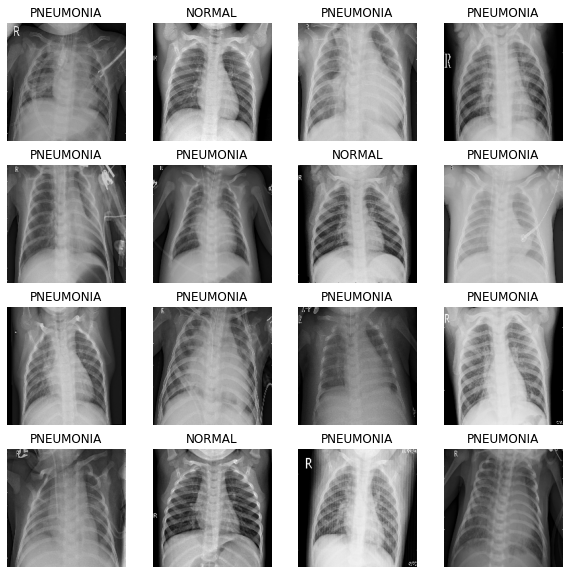

In [55]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [56]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [57]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [58]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리

In [59]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련

In [61]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [62]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 65s 199ms/step - loss: 0.4233 - accuracy: 0.7783 - precision: 0.9497 - recall: 0.7411 - val_loss: 0.5881 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 52s 198ms/step - loss: 0.2354 - accuracy: 0.9030 - precision: 0.9724 - recall: 0.8952 - val_loss: 1.5202 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 52s 198ms/step - loss: 0.2021 - accuracy: 0.9265 - precision: 0.9775 - recall: 0.9224 - val_loss: 0.9996 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 53s 203ms/step - loss: 0.1840 - accuracy: 0.9298 - precision: 0.9786 - recall: 0.9262 - val_loss: 0.2575 - val_accuracy: 0.8683 - val_precision: 0.8493 - val_recall: 0.9974
Epoch 5/10
261/261 [==============================] - 54s 206ms/step - loss: 0.1464 - accura

## 7. 결과 확인

이제 결과를 확인해보겠습니다. 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.

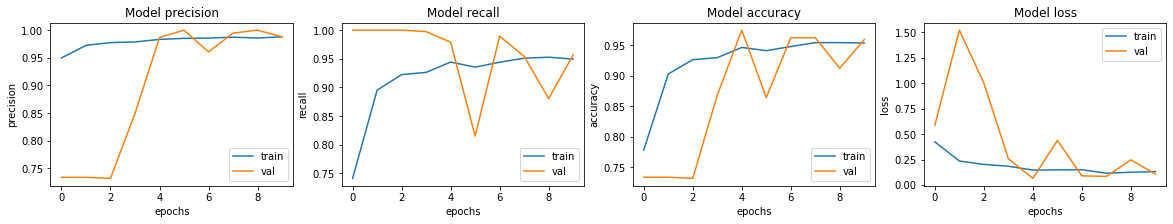

In [63]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [64]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 113ms/step - loss: 0.8347 - accuracy: 0.7596 - precision: 0.7299 - recall: 0.9769
Loss: 0.8347125053405762,
Accuracy: 0.7596153616905212,
Precision: 0.7298850417137146,
Recall: 0.9769230484962463


## 6-1. 프로젝트 : 폐렴 진단기 성능개선

In [79]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense

In [80]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10 
# 초기 학습률 설정
initial_learning_rate = 0.0001

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 가져오기

In [81]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

# $ mkdir -p ~/aiffel/chest_xray
# $ ln -s ~/data/ ~/aiffel/chest_xray

5216
624
16


In [82]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [57]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [58]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [83]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [84]:
# # 2-1 좌우 반전
# def augment(image,label):
#     image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#     return image,label

# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     # augment 적용 부분이 배치처리 함수에 추가되었습니다.
#     ds = ds.map(
#             augment,       # augment 함수 적용
#             num_parallel_calls=2
#         )
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)

#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

In [85]:
# #2-2 회전, 대비, 밝기, 색조, 채도 변경 (미적용)
# def augment(image,label):
#     # 이미지 회전
#     image = tf.image.rot90(image[0], k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
#     # 이미지 대비 강도 수정
#     image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
#     # 이미지 밝기 수정
#     image = tf.image.random_brightness(image, max_delta=0.3)
#     # 이미지 색조 변경
#     image = tf.image.random_hue(image, max_delta=0.1)
#     # 이미지 채도 변경
#     image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
#     return image, label

# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     # augment 적용 부분이 배치처리 함수에 추가되었습니다.
#     ds = ds.map(
#             augment,       # augment 함수 적용
#             num_parallel_calls=2
#         )
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)

#     return ds


In [86]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [87]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [88]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [89]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [90]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [91]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [92]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화

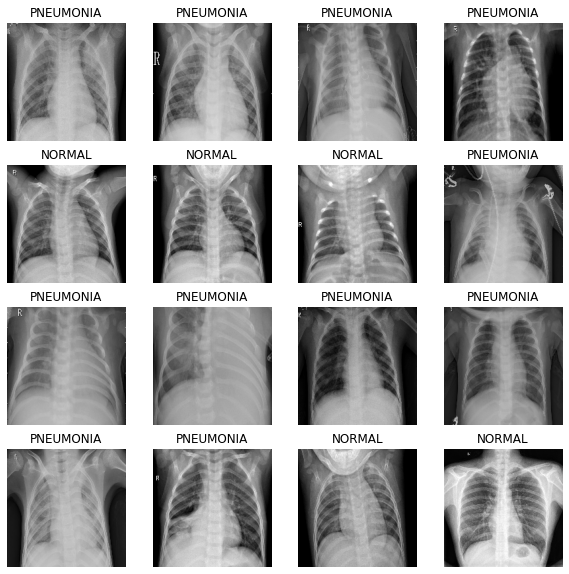

In [70]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. 데이터 imbalance 처리

'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었죠? 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다.

이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됩니다. Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다.

In [94]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 5. ResNet-18. 모델 훈련

시작 부분에는 크기가 7x7인 합성곱 필터(Convolutional filter)를 stride 2로 적용합니다.
그리고나서 3x3 최대 풀링(max pooling)을 stride 2로 진행합니다.

이후 2개의 Convolutional block을 적용합니다. 이 블록은 각각 2개의 3x3 합성곱 층을 갖습니다. 이 두 블록에서는 채널 수를 64개로 유지합니다.

그 다음으로는 병합 연산(identical shortcuts)을 도입한 2개의 합성곱목(Convolutional block)이 연속해 나옵니다. 첫 번째 블록에서 채널 수를 128개로 늘립니다.

같은 과정을 반복해서 채널 수를 256개, 그리고 512개로 늘립니다.
마지막으로는 전역 평균 풀링(Global Average Pooling)을 적용하고, 소프트맥스 함수를 통해 최종 클래스 예측을 Output으로 출력합니다.

In [95]:
# Resnet-18 추가
def conv_block(x, filters, kernel_size, strides=1):
    x_shortcut = x

    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Identity(skip) connection
    if strides != 1:
        x_shortcut = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='valid')(x_shortcut)
        x_shortcut = BatchNormalization()(x_shortcut)

    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)

    return x

def resnet18(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    x = conv_block(x, filters=64, kernel_size=3)
    x = conv_block(x, filters=64, kernel_size=3)
    x = conv_block(x, filters=128, kernel_size=3, strides=2)
    x = conv_block(x, filters=128, kernel_size=3)
    x = conv_block(x, filters=256, kernel_size=3, strides=2)
    x = conv_block(x, filters=256, kernel_size=3)
    x = conv_block(x, filters=512, kernel_size=3, strides=2)
    x = conv_block(x, filters=512, kernel_size=3)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다. 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언합니다.

이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용합니다. 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.

In [96]:
# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10 
# 초기 학습률 설정
initial_learning_rate = 0.0001

IMAGE_SIZE = 180
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

with tf.device('/GPU:0'):
    model = resnet18(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=1)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=METRICS
    )


모델을 fit 해보겠습니다. 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다.

In [97]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 63s 203ms/step - loss: 0.2086 - accuracy: 0.9128 - precision: 0.9705 - recall: 0.9106 - val_loss: 2.6951 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 51s 195ms/step - loss: 0.0994 - accuracy: 0.9612 - precision: 0.9874 - recall: 0.9601 - val_loss: 0.4056 - val_accuracy: 0.8038 - val_precision: 0.7895 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 53s 202ms/step - loss: 0.0543 - accuracy: 0.9796 - precision: 0.9938 - recall: 0.9787 - val_loss: 0.1080 - val_accuracy: 0.9558 - val_precision: 0.9556 - val_recall: 0.9856
Epoch 4/10
261/261 [==============================] - 53s 205ms/step - loss: 0.0559 - accuracy: 0.9787 - precision: 0.9941 - recall: 0.9772 - val_loss: 0.6838 - val_accuracy: 0.7308 - val_precision: 1.0000 - val_recall: 0.6325
Epoch 5/10
261/261 [==============================] - 52s 200ms/step - loss: 0.0355 - accura

## 7. 결과 확인

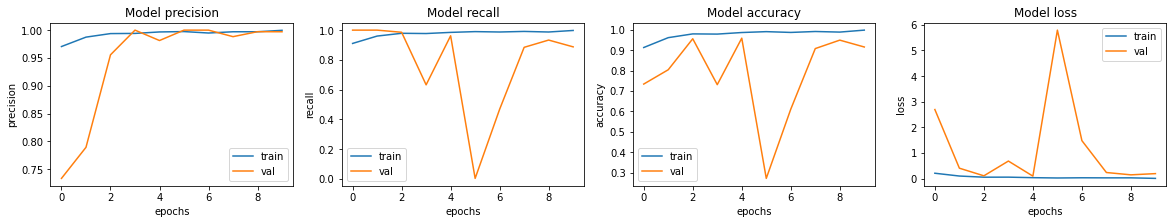

In [100]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [101]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')


39/39 [==============================] - 5s 116ms/step - loss: 0.7433 - accuracy: 0.8189 - precision: 0.7928 - recall: 0.9615
Loss: 0.743279218673706,
Accuracy: 0.8189102411270142,
Precision: 0.7928118109703064,
Recall: 0.9615384340286255


# 1차 .........좌우반전 안시키고
---
Epoch 1/10
261/261 [==============================] - 107s 203ms/step - loss: 0.1862 - accuracy: 0.9234 - precision: 0.9782 - recall: 0.9165 - val_loss: 3.3652 - val_accuracy: 0.7596 - val_precision: 0.7596 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 51s 197ms/step - loss: 0.0873 - accuracy: 0.9677 - precision: 0.9897 - recall: 0.9662 - val_loss: 0.5440 - val_accuracy: 0.7933 - val_precision: 0.7863 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 52s 200ms/step - loss: 0.0568 - accuracy: 0.9787 - precision: 0.9934 - recall: 0.9776 - val_loss: 0.0652 - val_accuracy: 0.9721 - val_precision: 0.9860 - val_recall: 0.9773
Epoch 4/10
261/261 [==============================] - 53s 202ms/step - loss: 0.0421 - accuracy: 0.9840 - precision: 0.9951 - recall: 0.9831 - val_loss: 0.0931 - val_accuracy: 0.9615 - val_precision: 0.9896 - val_recall: 0.9596
Epoch 5/10
261/261 [==============================] - 54s 207ms/step - loss: 0.0416 - accuracy: 0.9840 - precision: 0.9954 - recall: 0.9828 - val_loss: 0.2961 - val_accuracy: 0.9087 - val_precision: 0.9986 - val_recall: 0.8812
Epoch 6/10
261/261 [==============================] - 56s 217ms/step - loss: 0.0233 - accuracy: 0.9916 - precision: 0.9980 - recall: 0.9906 - val_loss: 0.1676 - val_accuracy: 0.9346 - val_precision: 0.9340 - val_recall: 0.9836
Epoch 7/10
261/261 [==============================] - 50s 190ms/step - loss: 0.0302 - accuracy: 0.9883 - precision: 0.9967 - recall: 0.9873 - val_loss: 0.1207 - val_accuracy: 0.9567 - val_precision: 0.9960 - val_recall: 0.9470
Epoch 8/10
261/261 [==============================] - 49s 188ms/step - loss: 0.0339 - accuracy: 0.9859 - precision: 0.9961 - recall: 0.9848 - val_loss: 0.1135 - val_accuracy: 0.9577 - val_precision: 0.9528 - val_recall: 0.9937
Epoch 9/10
261/261 [==============================] - 48s 186ms/step - loss: 0.0098 - accuracy: 0.9969 - precision: 0.9990 - recall: 0.9968 - val_loss: 0.1137 - val_accuracy: 0.9692 - val_precision: 0.9634 - val_recall: 0.9975
Epoch 10/10
261/261 [==============================] - 49s 186ms/step - loss: 0.0231 - accuracy: 0.9904 - precision: 0.9967 - recall: 0.9902 - val_loss: 0.2140 - val_accuracy: 0.9212 - val_precision: 0.9117 - val_recall: 0.9924

---
39/39 [==============================] - 4s 113ms/step - loss: 1.7940 - accuracy: 0.6571 - precision: 0.6457 - recall: 1.0000
Loss: 1.7940261363983154,
Accuracy: 0.6570512652397156,
Precision: 0.6456953883171082,
Recall: 1.0

---
---

# 2차 .........좌우반전 시키고..

---
Epoch 1/10
261/261 [==============================] - 62s 201ms/step - loss: 0.1946 - accuracy: 0.9236 - precision: 0.9784 - recall: 0.9176 - val_loss: 2.1648 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 52s 199ms/step - loss: 0.0821 - accuracy: 0.9698 - precision: 0.9901 - recall: 0.9691 - val_loss: 1.0177 - val_accuracy: 0.7481 - val_precision: 0.7446 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 52s 200ms/step - loss: 0.0493 - accuracy: 0.9840 - precision: 0.9964 - recall: 0.9820 - val_loss: 0.1469 - val_accuracy: 0.9452 - val_precision: 0.9889 - val_recall: 0.9359
Epoch 4/10
261/261 [==============================] - 52s 201ms/step - loss: 0.0464 - accuracy: 0.9832 - precision: 0.9958 - recall: 0.9816 - val_loss: 0.2683 - val_accuracy: 0.8990 - val_precision: 0.9985 - val_recall: 0.8642
Epoch 5/10
261/261 [==============================] - 53s 204ms/step - loss: 0.0344 - accuracy: 0.9866 - precision: 0.9974 - recall: 0.9845 - val_loss: 0.4949 - val_accuracy: 0.8423 - val_precision: 0.8233 - val_recall: 1.0000
Epoch 6/10
261/261 [==============================] - 54s 207ms/step - loss: 0.0302 - accuracy: 0.9899 - precision: 0.9964 - recall: 0.9900 - val_loss: 8.1748 - val_accuracy: 0.3096 - val_precision: 1.0000 - val_recall: 0.0627
Epoch 7/10
261/261 [==============================] - 57s 218ms/step - loss: 0.0307 - accuracy: 0.9902 - precision: 0.9977 - recall: 0.9891 - val_loss: 0.0634 - val_accuracy: 0.9750 - val_precision: 0.9744 - val_recall: 0.9922
Epoch 8/10
261/261 [==============================] - 49s 188ms/step - loss: 0.0151 - accuracy: 0.9940 - precision: 0.9984 - recall: 0.9936 - val_loss: 0.1320 - val_accuracy: 0.9510 - val_precision: 0.9419 - val_recall: 0.9948
Epoch 9/10
261/261 [==============================] - 49s 187ms/step - loss: 0.0177 - accuracy: 0.9947 - precision: 0.9984 - recall: 0.9945 - val_loss: 0.0649 - val_accuracy: 0.9731 - val_precision: 0.9829 - val_recall: 0.9803
Epoch 10/10
261/261 [==============================] - 50s 191ms/step - loss: 0.0203 - accuracy: 0.9938 - precision: 0.9981 - recall: 0.9936 - val_loss: 0.2698 - val_accuracy: 0.9096 - val_precision: 1.0000 - val_recall: 0.8771

---
39/39 [==============================] - 5s 119ms/step - loss: 0.5238 - accuracy: 0.8622 - precision: 0.8602 - recall: 0.9308
Loss: 0.523777186870575,
Accuracy: 0.8621794581413269,
Precision: 0.8601895570755005,
Recall: 0.9307692050933838

---
---
# 3차 .........좌우반전/회전, 대비, 밝기, 색조, 채도 변경  시키고..

---
Epoch 1/10
261/261 [==============================] - 63s 204ms/step - loss: 0.1959 - accuracy: 0.9222 - precision: 0.9767 - recall: 0.9173 - val_loss: 3.1957 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 52s 200ms/step - loss: 0.0914 - accuracy: 0.9665 - precision: 0.9898 - recall: 0.9649 - val_loss: 0.6203 - val_accuracy: 0.8010 - val_precision: 0.7864 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 51s 198ms/step - loss: 0.0525 - accuracy: 0.9787 - precision: 0.9938 - recall: 0.9775 - val_loss: 0.3929 - val_accuracy: 0.8173 - val_precision: 0.9897 - val_recall: 0.7588
Epoch 4/10
261/261 [==============================] - 52s 201ms/step - loss: 0.0429 - accuracy: 0.9837 - precision: 0.9954 - recall: 0.9826 - val_loss: 0.2288 - val_accuracy: 0.9269 - val_precision: 0.9155 - val_recall: 0.9921
Epoch 5/10
261/261 [==============================] - 53s 204ms/step - loss: 0.0414 - accuracy: 0.9830 - precision: 0.9958 - recall: 0.9813 - val_loss: 0.6839 - val_accuracy: 0.8067 - val_precision: 1.0000 - val_recall: 0.7366
Epoch 6/10
261/261 [==============================] - 54s 208ms/step - loss: 0.0201 - accuracy: 0.9931 - precision: 0.9971 - recall: 0.9936 - val_loss: 0.8190 - val_accuracy: 0.6981 - val_precision: 1.0000 - val_recall: 0.5879
Epoch 7/10
261/261 [==============================] - 56s 214ms/step - loss: 0.0252 - accuracy: 0.9902 - precision: 0.9977 - recall: 0.9891 - val_loss: 0.0950 - val_accuracy: 0.9683 - val_precision: 0.9919 - val_recall: 0.9647
Epoch 8/10
261/261 [==============================] - 49s 187ms/step - loss: 0.0203 - accuracy: 0.9935 - precision: 0.9981 - recall: 0.9932 - val_loss: 0.9880 - val_accuracy: 0.6404 - val_precision: 0.9974 - val_recall: 0.5118
Epoch 9/10
261/261 [==============================] - 49s 190ms/step - loss: 0.0226 - accuracy: 0.9907 - precision: 0.9977 - recall: 0.9897 - val_loss: 0.0735 - val_accuracy: 0.9692 - val_precision: 0.9777 - val_recall: 0.9803
Epoch 10/10
261/261 [==============================] - 49s 187ms/step - loss: 0.0093 - accuracy: 0.9966 - precision: 0.9994 - recall: 0.9961 - val_loss: 0.0999 - val_accuracy: 0.9721 - val_precision: 0.9959 - val_recall: 0.9658

---
39/39 [==============================] - 5s 118ms/step - loss: 0.9214 - accuracy: 0.8349 - precision: 0.7971 - recall: 0.9872
Loss: 0.9214202761650085,
Accuracy: 0.8349359035491943,
Precision: 0.7971014380455017,
Recall: 0.9871794581413269


---
# 4차 .........좌우반전/회전, 대비, 밝기, 색조, 채도 변경  안시키고..
---

Epoch 1/10
261/261 [==============================] - 63s 203ms/step - loss: 0.2086 - accuracy: 0.9128 - precision: 0.9705 - recall: 0.9106 - val_loss: 2.6951 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 51s 195ms/step - loss: 0.0994 - accuracy: 0.9612 - precision: 0.9874 - recall: 0.9601 - val_loss: 0.4056 - val_accuracy: 0.8038 - val_precision: 0.7895 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 53s 202ms/step - loss: 0.0543 - accuracy: 0.9796 - precision: 0.9938 - recall: 0.9787 - val_loss: 0.1080 - val_accuracy: 0.9558 - val_precision: 0.9556 - val_recall: 0.9856
Epoch 4/10
261/261 [==============================] - 53s 205ms/step - loss: 0.0559 - accuracy: 0.9787 - precision: 0.9941 - recall: 0.9772 - val_loss: 0.6838 - val_accuracy: 0.7308 - val_precision: 1.0000 - val_recall: 0.6325
Epoch 5/10
261/261 [==============================] - 52s 200ms/step - loss: 0.0355 - accuracy: 0.9864 - precision: 0.9967 - recall: 0.9849 - val_loss: 0.0957 - val_accuracy: 0.9587 - val_precision: 0.9813 - val_recall: 0.9621
Epoch 6/10
261/261 [==============================] - 54s 209ms/step - loss: 0.0233 - accuracy: 0.9907 - precision: 0.9974 - recall: 0.9900 - val_loss: 5.7942 - val_accuracy: 0.2712 - val_precision: 1.0000 - val_recall: 0.0039
Epoch 7/10
261/261 [==============================] - 56s 214ms/step - loss: 0.0313 - accuracy: 0.9868 - precision: 0.9948 - recall: 0.9875 - val_loss: 1.4807 - val_accuracy: 0.6106 - val_precision: 1.0000 - val_recall: 0.4685
Epoch 8/10
261/261 [==============================] - 49s 189ms/step - loss: 0.0283 - accuracy: 0.9914 - precision: 0.9971 - recall: 0.9913 - val_loss: 0.2367 - val_accuracy: 0.9077 - val_precision: 0.9883 - val_recall: 0.8845
Epoch 9/10
261/261 [==============================] - 49s 189ms/step - loss: 0.0288 - accuracy: 0.9885 - precision: 0.9971 - recall: 0.9874 - val_loss: 0.1460 - val_accuracy: 0.9490 - val_precision: 0.9972 - val_recall: 0.9332
Epoch 10/10
261/261 [==============================] - 50s 191ms/step - loss: 0.0075 - accuracy: 0.9981 - precision: 0.9997 - recall: 0.9978 - val_loss: 0.1935 - val_accuracy: 0.9154 - val_precision: 0.9971 - val_recall: 0.8876

---
39/39 [==============================] - 5s 116ms/step - loss: 0.7433 - accuracy: 0.8189 - precision: 0.7928 - recall: 0.9615
Loss: 0.743279218673706,
Accuracy: 0.8189102411270142,
Precision: 0.7928118109703064,
Recall: 0.9615384340286255



